<a href="https://colab.research.google.com/github/tjdux/basic_of_ml/blob/main/22_imdb_reviews_classification_using_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMDB 리뷰 데이터셋
- 자연어 처리(natural language processing; NLP): 컴퓨터를 사용해 인간의 언어를 처리하는 분야
- 말뭉치(corpus): 자연어 처리 분야에서의 훈련 데이터
- 어휘 사전: 훈련 세트에서 고유한 단어를 뽑아 만든 목록
- 텍스트 데이터의 단어마다 고유한 정수를 부여하여 숫자 데이터로 변환
  - 동일한 단어는 동일한 정수
  - 단어에 매핑되는 정수는 단어의 의미나 크기와 관련 없음
  - 정숫값 사이에는 어떠한 관계도 없음
  - 정수 중 몇 개는 특정한 용도로 예약되어 있는 경우가 많음
    - 0: 패딩
    - 1: 문장의 시작
    - 2: 어휘 사전에 없는 토큰
- 토큰 (token)
  - (영어 기준) 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리된 단어
  - 하나의 샘플은 여러 개의 토큰으로 이루어져 있음
  - 하나의 토큰은 하나의 타임스텝에 해당  

In [1]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=300)
# 300개의 단어가 있는 어휘사전 (전체 데이터셋에서 가장 자주 등장하는 단어 300개)

In [2]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


- 1차원 배열인 이유: 텍스트 길이가 제각각이므로 2차원 배열보다는 리뷰마다 별도의 파이썬 리스트에 담아야 메모리 효율이 증대

In [3]:
print(f"첫 번째 리뷰의 길이: {len(train_input[0])}")
print(f"두 번째 리뷰의 길이: {len(train_input[1])}")

첫 번째 리뷰의 길이: 218
두 번째 리뷰의 길이: 189


In [4]:
print(f"첫 번째 리뷰:\n{train_input[0]}")

첫 번째 리뷰:
[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 284, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


- 어휘 사전 (300개 단어)에 없는 단어는 2로 표시

In [5]:
print(f"타깃 데이터: {train_target[:20]}")

타깃 데이터: [1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


- 이진 분류 문제 👉 타깃값이 0(부정)과 1(긍정)

In [6]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

In [7]:
import numpy as np

lengths = np.array([len(x) for x in train_input])
print(f"리뷰 길이의 평균: {np.mean(lengths)}")
print(f"리뷰 길이의 중간값: {np.median(lengths)}")

리뷰 길이의 평균: 239.00925
리뷰 길이의 중간값: 178.0


- 👉 평균이 중간값보다 훨씬 큼: 한쪽으로 치우친 분포

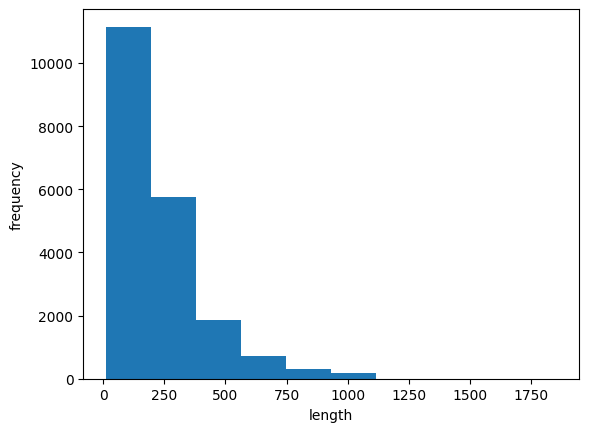

In [8]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel("length")
plt.ylabel("frequency")
plt.show()

- 중간값보다 훨씬 짧은 100개의 단어만 사용
- 100개의 단어보다 작은 리뷰: 패딩 (토큰 0)을 사용하여 길이를 100에 맞추기

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
# maxlen보다 긴 경우는 잘라내고 짧은 경우는 0으로 패딩

In [10]:
print(train_seq.shape)

(20000, 100)


In [11]:
print(f"첫 번째 샘플: {train_seq[0]}")

첫 번째 샘플: [ 10   4  20   9   2   2   2   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [12]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


- 👉 샘플의 앞부분이 잘림
- `pad_sequences()`
  - `maxlen` 매개변수보다 긴 시퀀스의 앞부분을 자름
  - 일반적으로 시퀀스의 뒷부분의 정보가 더 유용하리라 기대하기 때문
  - `truncating="post"`로 변경하여 뒷부분 자르기 가능

In [13]:
print(f"여섯 번째 샘플: {train_seq[5]}")

여섯 번째 샘플: [  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94 205   2  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


- 👉 패딩 토큰은 시퀀스의 앞부분에 추가됨
- 시퀀스의 마지막에 있는 단어가 셀의 은닉 상태에 가장 큰 영향을 미치게 되므로 마지막에 패딩을 추가하는 것은 일반적으로 선호되지 않음
- `padding="post"` 매개변수 변경으로 뒷부분에 패딩 추가 가능

In [14]:
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기
- 이진 분류 ➡️ 마지막 출력층은 1개의 뉴런, 시그모이드 활성화 함수 사용

In [15]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 300)))
model.add(keras.layers.Dense(1, activation="sigmoid"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- `keras.layers.SimpleRNN` 매개변수
  - 첫 번째: 사용할 뉴런의 개수
  - 입력차원 `(100, 300)`: 원-핫 인코딩을 할 것이기 때문에 (100개의 단어, 단어 300개의 어휘사전)
  - `activation`: 기본값 `tanh`
- 원-핫 인코딩
  - 문제점: 토큰을 정수로 변환한 데이터를 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만듦 (정수 사이에는 어떤 관련도 없는데도!)
  - 원-핫 인코딩을 통해 정숫값에 있는 크기 속성을 없애고 각 정수를 고유하게 표현
- `keras.utils.to_categorical()`: 원-핫 인코딩

In [16]:
train_oh = keras.utils.to_categorical(train_seq)
print(f"train_oh의 크기: {train_oh.shape}")

train_oh의 크기: (20000, 100, 300)


In [17]:
print(f"인코딩된 첫 번째 샘플의 토큰 10 (첫 번째 토큰): {train_oh[0][0][:12]}")
print(f"인코딩된 첫 번째 샘플의 첫 번째 토큰의 모든 원소의 합: {np.sum(train_oh[0][0])}")

인코딩된 첫 번째 샘플의 토큰 10 (첫 번째 토큰): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
인코딩된 첫 번째 샘플의 첫 번째 토큰의 모든 원소의 합: 1.0


In [18]:
val_oh = keras.utils.to_categorical(val_seq)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 8)              │         2,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,481 (9.69 KB)

 Trainable params: 2,481 (9.69 KB)

 Non-trainable params: 0 (0.00 B)

- `SimpleRNN`
  - 출력의 크기: 순환층 뉴런 개수와 동일한 8 (순환층은 마지막 타임스텝의 은닉 상태만 출력하므로)
  - 파라미터 개수: 300 * 8 + 8 * 8 + 8 = 2472

## 순환 신경망 훈련하기

In [20]:
# rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
# model.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
# checkpoint_cb = keras.callbacks.ModelCheckpoint("best-simplernn-model.h5", save_best_only=True)
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
# history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
#                     validation_data=(val_oh, val_target),
#                     callbacks=[checkpoint_cb, early_stopping_cb])

In [21]:
# plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.legend(["train", "val"])
# plt.show()

- 원-핫 인코딩의 단점: 입력 데이터가 엄청나게 커짐

## 단어 임베딩 (word embedding)
- 각 단어를 고정된 크기의 실수 벡터로 바꿔줌
- 원-핫 인코딩된 벡터보다 훨씬 의미 있는 값으로 채워져 있기 때문에 자연어 처리에서 더 좋은 성능을 내는 경우가 많음
- `keras.layers.Embedding`에서 임베딩 기능 제공
  - 처음에는 모든 벡터가 랜덤하게 초기화되지만 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습
- 장점: 입력으로 정수 데이터를 받음 ➡️ 메모리를 훨씬 효율적으로 사용 가능
- 훨씬 작은 크기로도 단어를 잘 표현할 수 있음

In [22]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(300, 16))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation="sigmoid"))

- `Embedding`의 매개변수
  - 첫 번째: 어휘 사전의 크기
  - 두 번째: 임베딩 벡터의 크기

In [23]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

- `Embedding`
  - 파라미터 개수: 300 * 16 = 4800
- `SimpleRNN`
  - 파라미터 개수: 16 * 8 + 8 * 8 + 8 = 200

In [24]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-simplernn-model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4916 - loss: 0.7018

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.4916 - loss: 0.7018 - val_accuracy: 0.5216 - val_loss: 0.6918
Epoch 2/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5323 - loss: 0.6887

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5324 - loss: 0.6887 - val_accuracy: 0.5758 - val_loss: 0.6802
Epoch 3/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5953 - loss: 0.6732

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5953 - loss: 0.6731 - val_accuracy: 0.6536 - val_loss: 0.6342
Epoch 4/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6748 - loss: 0.6056

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6750 - loss: 0.6055 - val_accuracy: 0.7126 - val_loss: 0.5744
Epoch 5/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7114 - loss: 0.5703

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7114 - loss: 0.5703 - val_accuracy: 0.7090 - val_loss: 0.5707
Epoch 6/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7339 - loss: 0.5473

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7339 - loss: 0.5473 - val_accuracy: 0.7376 - val_loss: 0.5385
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7370 - loss: 0.5400 - val_accuracy: 0.7234 - val_loss: 0.5497
Epoch 8/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7407 - loss: 0.5345

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7407 - loss: 0.5345 - val_accuracy: 0.7438 - val_loss: 0.5288
Epoch 9/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7519 - loss: 0.5205

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7519 - loss: 0.5205 - val_accuracy: 0.7432 - val_loss: 0.5220
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7503 - loss: 0.5219

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7503 - loss: 0.5219 - val_accuracy: 0.7492 - val_loss: 0.5178
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7551 - loss: 0.5167 - val_accuracy: 0.7472 - val_loss: 0.5182
Epoch 12/100
309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7594 - loss: 0.5117

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7594 - loss: 0.5117 - val_accuracy: 0.7458 - val_loss: 0.5172
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7575 - loss: 0.5125

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7575 - loss: 0.5124 - val_accuracy: 0.7490 - val_loss: 0.5107
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7607 - loss: 0.5082 - val_accuracy: 0.7316 - val_loss: 0.5372
Epoch 15/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7648 - loss: 0.5012 - val_accuracy: 0.7388 - val_loss: 0.5216
Epoch 16/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7619 - loss: 0.5046 - val_accuracy: 0.7326 - val_loss: 0.5326


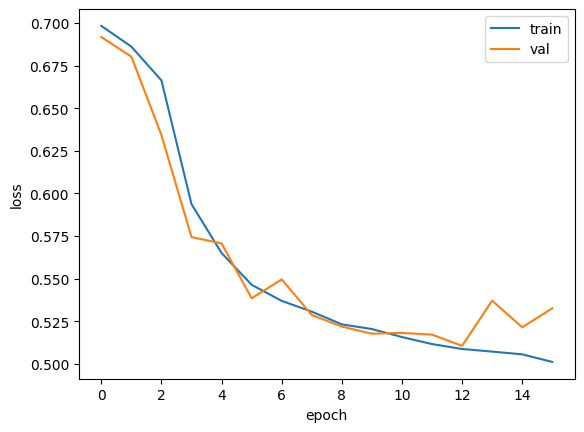

In [25]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()